## Outline

1. Recap of what we did last time
2. Why do we use batching
3. Batching for sequence models
4. Padding and packing in PyTorch
5. Training with batched dataset
6. Comparison of performance with batching and on GPU

### Setting up the dependencies

In [0]:
from io import open
import os, string, random, time, math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim

# Instantiates the device to be used as GPU/CPU based on availability
device_gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [0]:
from IPython.display import clear_output

## Dataset

### Pre-processing

In [0]:
languages = []
data = []
X = []
y = []

with open('name2lang.txt', 'r') as f: 
    for line in f:
        line = line.split(',')
        name = line[0].strip()
        lang = line[1].strip()
        if not lang in languages:
            languages.append(lang)
        X.append(name)
        y.append(lang)
        data.append((name, lang))

n_languages = len(languages)

In [84]:
print(languages)

['Portuguese', 'Irish', 'Spanish', 'Vietnamese', 'Chinese', 'Greek', 'Czech', 'Dutch', 'Japanese', 'French', 'German', 'Scottish', 'English', 'Russian', 'Polish', 'Arabic', 'Korean', 'Italian']


In [85]:
print(data[0:10])

[('Abreu', 'Portuguese'), ('Albuquerque', 'Portuguese'), ('Almeida', 'Portuguese'), ('Alves', 'Portuguese'), ('Araujo', 'Portuguese'), ('Araullo', 'Portuguese'), ('Barros', 'Portuguese'), ('Basurto', 'Portuguese'), ('Belo', 'Portuguese'), ('Cabral', 'Portuguese')]


### Test-train split

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [87]:
print(X_train)

['Abashkin', 'Gulimov', 'Tzelobenok', 'Funnell', 'Zhui', 'Jukes', 'Togunov', 'Sabbag', 'Kartomyshev', 'Makhnenko', 'Sokolsky', 'Masuno', 'Varela', 'Moffat', 'Bonner', 'Berezovsky', 'Helkvist', 'Thurston', 'Tovstuha', 'Millar', 'Tulintsev', 'Furey', 'Isaenko', 'Kalachev', 'Takecare', 'Newcombe', 'Taku', 'Artibyakin', 'Saifulov', 'Morcos', 'Jagodnikov', 'Halifman', 'Bagaryakoff', 'Pavluhin', 'Mari', 'Awramchik', 'Agaltsov', 'Fisichev', 'Shizuma', 'Yankin', 'Luts', 'Toshitala', 'Germain', 'Botros', 'Poulter', 'Lischenko', 'Porter', 'Melendez', 'Ibu', 'Carr', 'Ursler', 'Aderikhin', 'Gimondi', 'Rzhevsky', 'Slater', 'Atkin', 'Yagafarov', 'Huraskin', 'Underhill', 'Pylin', 'Yuschenko', 'Ardovini', 'Tunison', 'Dobrovolsky', 'Bezyzvestnyh', 'Roussel', 'Balakshin', 'Trumbauer', 'Vallance', 'Boerio', 'Waugh', 'Baz', 'Reading', 'Komon', 'Ireson', 'Venables', 'Tikhotsky', 'Spada', 'Winfield', 'Mikhnov', 'Lubsky', 'Antar', 'Sheehan', 'Tuma', 'Yuzefovich', 'Yamburg', 'Yukhvidov', 'Mikhail', 'Chi', 'De

In [88]:
print(len(X_train), len(X_test))

16040 4010


### Encoding names and language

In [0]:
all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

In [0]:
def name_rep(name):
    rep = torch.zeros(len(name), 1, n_letters)
    for index, letter in enumerate(name):
        pos = all_letters.find(letter)
        rep[index][0][pos] = 1
    return rep

In [0]:
def lang_rep(lang):
    return torch.tensor([languages.index(lang)], dtype=torch.long)

In [94]:
name_rep('Abreu')

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0

In [95]:
lang_rep('Portuguese')

tensor([0])

### Basic visualisation

In [0]:
count = {}
for l in languages: 
    count[l] = 0
for d in data:
    count[d[1]] += 1

In [97]:
print(count)

{'Portuguese': 74, 'Irish': 232, 'Spanish': 298, 'Vietnamese': 73, 'Chinese': 268, 'Greek': 203, 'Czech': 519, 'Dutch': 297, 'Japanese': 991, 'French': 277, 'German': 724, 'Scottish': 100, 'English': 3668, 'Russian': 9384, 'Polish': 139, 'Arabic': 2000, 'Korean': 94, 'Italian': 709}


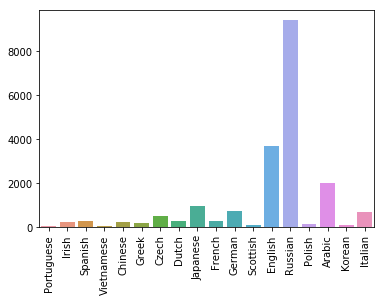

In [98]:
plt_ = sns.barplot(list(count.keys()), list(count.values()))
plt_.set_xticklabels(plt_.get_xticklabels(), rotation=90)
plt.show()

## Basic network and testing inference

In [0]:
class RNN_net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_net, self).__init__()
        self.hidden_size = hidden_size
        self.rnn_cell = nn.RNN(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input_, hidden = None, batch_size = 1):
        out, hidden = self.rnn_cell(input_, hidden)
        output = self.h2o(hidden.view(-1, self.hidden_size))
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self, batch_size = 1):
        return torch.zeros(1, batch_size, self.hidden_size)

In [0]:
n_hidden = 128
net = RNN_net(n_letters, n_hidden, n_languages)

In [0]:
def infer(net, name, device = 'cpu'):
    name_ohe = name_rep(name).to(device)
    
    output, hidden = net(name_ohe)
        
    if type(hidden) is tuple: # For LSTM
        hidden = hidden[0]
    index = torch.argmax(hidden)
    
    return output

In [102]:
infer(net, 'Adam')

tensor([[-2.9282, -2.8429, -2.9049, -2.9089, -2.8789, -2.9408, -2.9705, -2.8872,
         -2.8911, -2.8392, -2.8727, -2.9157, -2.9218, -2.8612, -2.9943, -2.8023,
         -2.9621, -2.7373]], grad_fn=<LogSoftmaxBackward>)

## Evaluate model

In [0]:
def dataloader(npoints, X_, y_):
    to_ret = []
    for i in range(npoints):
        index_ = np.random.randint(len(X_))
        name, lang = X_[index_], y_[index_]
        to_ret.append((name, lang, name_rep(name), lang_rep(lang)))
    return to_ret

In [104]:
dataloader(2, X_train, y_train)

[('Frierdich',
  'Czech',
  tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0.]],
  
          [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0.]],
  
          [[0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0.]],
  
          [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [0]:
def eval(net, n_points, topk, X_, y_, device = 'cpu'):
    net = net.eval().to(device)
    data_ = dataloader(n_points, X_, y_)
    correct = 0
    
    for name, language, name_ohe, lang_rep in data_:
        
        output = infer(net, name, device)
        val, indices = output.topk(topk)
        indices = indices.to('cpu')
        
        if lang_rep in indices:
            correct += 1
            
    accuracy = correct/n_points
    return accuracy

In [106]:
eval(net, 1000, 1, X_test, y_test)

0.036

# Batching

In [0]:
def batched_name_rep(names, max_word_size):
    rep = torch.zeros(max_word_size, len(names), n_letters)
    for name_index, name in enumerate(names):
        for letter_index, letter in enumerate(name):
            pos = all_letters.find(letter)
            rep[letter_index][name_index][pos] = 1
    return rep

In [0]:
def print_char(name_reps):
    name_reps = name_reps.view((-1, name_reps.size()[-1]))
    for t in name_reps: 
        if torch.sum(t) == 0:
            print('<pad>')
        else:
            index = t.argmax()
            print(all_letters[index])

In [109]:
out_ = batched_name_rep(['Shyam', 'Ram'], 5)
print(out_)
print(out_.shape)
print_char(out_)

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.],
         [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0

In [0]:
def batched_lang_rep(langs):
    rep = torch.zeros([len(langs)], dtype=torch.long)
    for index, lang in enumerate(langs):
        rep[index] = languages.index(lang)
    return rep

In [0]:
def batched_dataloader(npoints, X_, y_, verbose=False, device = 'cpu'):
    names = []
    langs = []
    X_lengths = []
    
    for i in range(npoints):
        index_ = np.random.randint(len(X_))
        name, lang = X_[index_], y_[index_]
        X_lengths.append(len(name))
        names.append(name)
        langs.append(lang)
    max_length = max(X_lengths)
    
    names_rep = batched_name_rep(names, max_length).to(device)
    langs_rep = batched_lang_rep(langs).to(device)
    
    padded_names_rep = torch.nn.utils.rnn.pack_padded_sequence(names_rep, X_lengths, enforce_sorted = False)
    
    if verbose:
        print(names_rep.shape, padded_names_rep.data.shape)
        print('--')
    
    if verbose:
        print(names)
        print_char(names_rep)
        print('--')
    
    if verbose:
        print_char(padded_names_rep.data)
        print('Lang Rep', langs_rep.data)
        print('Batch sizes', padded_names_rep.batch_sizes)
    
    
    return padded_names_rep.to(device), langs_rep

In [115]:
p, l = batched_dataloader(3, X_train, y_train, True)

torch.Size([9, 3, 57]) torch.Size([21, 57])
--
['Groel', 'Mustafa', 'Shalyugin']
G
M
S
r
u
h
o
s
a
e
t
l
l
a
y
<pad>
f
u
<pad>
a
g
<pad>
<pad>
i
<pad>
<pad>
n
--
S
M
G
h
u
r
a
s
o
l
t
e
y
a
l
u
f
g
a
i
n
Lang Rep tensor([10, 15, 13])
Batch sizes tensor([3, 3, 3, 3, 3, 2, 2, 1, 1])


## Training

### Basic setup

In [0]:
def train(net, opt, criterion, n_points):
    
    opt.zero_grad()
    total_loss = 0
    
    data_ = dataloader(n_points, X_train, y_train)
    
    total_loss = 0
    
    for name, language, name_ohe, lang_rep in data_:

        hidden = net.init_hidden()

        for i in range(name_ohe.size()[0]):
            output, hidden = net(name_ohe[i:i+1], hidden)
            
        loss = criterion(output, lang_rep)
        loss.backward(retain_graph=True)
        
        total_loss += loss
        
    opt.step()       
    return total_loss/n_points

In [0]:
def train_batch(net, opt, criterion, n_points, device = 'cpu'):
    
    net.train().to(device)
    opt.zero_grad()
    
    batch_input, batch_groundtruth = batched_dataloader(n_points, X_train, y_train, False, device)
    
    output, hidden = net(batch_input)
    
    loss = criterion(output, batch_groundtruth)
    
    loss.backward()
    opt.step()
    return loss

In [0]:
net = RNN_net(n_letters, n_hidden, n_languages)
criterion = nn.NLLLoss()
opt = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [118]:
%%time 
train(net, opt, criterion, 256)

CPU times: user 749 ms, sys: 34.4 ms, total: 784 ms
Wall time: 798 ms


tensor(2.9031, grad_fn=<DivBackward0>)

In [0]:
net = RNN_net(n_letters, n_hidden, n_languages)
criterion = nn.NLLLoss()
opt = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [120]:
%%time 
train_batch(net, opt, criterion, 256)

CPU times: user 47.6 ms, sys: 1.97 ms, total: 49.5 ms
Wall time: 51.8 ms


tensor(2.9061, grad_fn=<NllLossBackward>)

### Full training setup

In [0]:
def train_setup(net, lr = 0.01, n_batches = 100, batch_size = 10, momentum = 0.9, display_freq=5, device = 'cpu'):
    net = net.to(device)
    criterion = nn.NLLLoss()
    opt = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    
    loss_arr = np.zeros(n_batches + 1)
    
    for i in range(n_batches):
        loss_arr[i+1] = (loss_arr[i]*i + train_batch(net, opt, criterion, batch_size, device))/(i + 1)
        
        if i%display_freq == display_freq-1:
            clear_output(wait=True)
            
            print('Iteration', i, 'Loss', loss_arr[i])
            # print('Top-1:', eval(net, len(X_test), 1, X_test, y_test), 'Top-2:', eval(net, len(X_test), 2, X_test, y_test))
            plt.figure()
            plt.plot(loss_arr[1:i], '-*')
            plt.xlabel('Iteration')
            plt.ylabel('Loss')
            plt.show()
            print('\n\n')
            
    print('Top-1:', eval(net, len(X_test), 1, X_test, y_test, device), 'Top-2:', eval(net, len(X_test), 2, X_test, y_test, device))
                      

## RNN Cell

Iteration 4999 Loss 0.4492100477218628


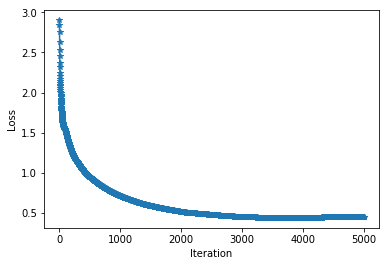




Top-1: 0.7790523690773067 Top-2: 0.8810473815461347
CPU times: user 6min 28s, sys: 19.6 s, total: 6min 48s
Wall time: 6min 46s


In [68]:
%%time
net = RNN_net(n_letters, 128, n_languages)
train_setup(net, lr=0.15, n_batches=5000, batch_size = 512, display_freq=500) # CPU Training example

Iteration 4999 Loss 0.46217286586761475


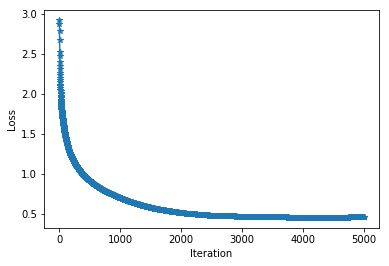




Top-1: 0.7351620947630922 Top-2: 0.8329177057356608
CPU times: user 5min 12s, sys: 29.5 s, total: 5min 41s
Wall time: 5min 32s


In [69]:
%%time
net = RNN_net(n_letters, 128, n_languages)
train_setup(net, lr=0.15, n_batches=5000, batch_size = 512, display_freq=100, device = device_gpu) # GPU Training Example

## LSTM cell

In [0]:
class LSTM_net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM_net, self).__init__()
        self.hidden_size = hidden_size
        self.lstm_cell = nn.LSTM(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden = None):
        out, hidden = self.lstm_cell(input, hidden)
        output = self.h2o(hidden[0].view(-1, self.hidden_size))
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self, batch_size = 1):
        return (torch.zeros(1, batch_size, self.hidden_size), torch.zeros(1, batch_size, self.hidden_size))

Iteration 7999 Loss 0.24914832413196564


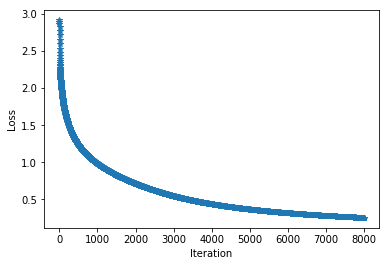




Top-1: 0.8 Top-2: 0.8842892768079801


In [75]:
n_hidden = 128
net = LSTM_net(n_letters, n_hidden, n_languages)
train_setup(net, lr=0.15, n_batches=8000, batch_size = 512, display_freq=1000, device = device_gpu)

## GRU Cell

In [0]:
class GRU_net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU_net, self).__init__()
        self.hidden_size = hidden_size
        self.gru_cell = nn.GRU(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input, hidden = None):
        out, hidden = self.gru_cell(input, hidden)
        output = self.h2o(hidden.view(-1, self.hidden_size))
        output = self.softmax(output)
        return output, hidden

Iteration 7999 Loss 0.2180105596780777


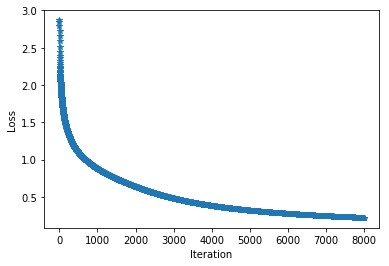




Top-1: 0.7900249376558603 Top-2: 0.8825436408977556


In [76]:
n_hidden = 128
net = GRU_net(n_letters, n_hidden, n_languages)
train_setup(net, lr=0.15, n_batches=8000, batch_size = 512, display_freq=1000, device = device_gpu)